# Part 1: Network Training

## Step0: Import Package & Hyperparameter Configuration

### Package

In [198]:
%reset -f

import os
import torch
import random
import numpy as np
import random
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

### Hyperparameter Config

In [199]:
# %%
# Unified Hyperparameter Configuration
class Config:
    SEED = 1
    # NUM_EPOCHS = 2000
    BATCH_SIZE = 128
    # LEARNING_RATE = 0.002
    # LR_SCHEDULER_GAMMA = 0.99
    # DECAY_EPOCH = 200
    # DECAY_RATIO = 0.5
    # EARLY_STOPPING_PATIENCE = 500
    HIDDEN_SIZE = 30
    OPERATOR_SIZE = 30


# Reproducibility
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Material & Number of Data

In [200]:
material = "CH467160"
epcho = 3000
downsample = 1024

way = "range"
# way = "linspace"
# way = "adaptive"

# 定義保存模型的路徑
model_save_dir = f"./Model/{way}/{downsample}/"
# 定義模型保存檔名
model_save_path = os.path.join(model_save_dir, f"{material}_{downsample}.pt")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step1: Data processing and data loader generate 

In [ ]:
# %% Preprocess data into a data loader
def get_dataloader(data_B,
                   data_F,
                   data_T,
                   data_H,
                   data_N,
                   data_Hdc,
                   data_Pcv,
                   norm,
                   n_init=16):
    """ #*(Date:250105)
    Process data and return DataLoader for training, validation, and testing.

    Parameters
    ----------
    data_B : np.array
        Magnetic flux density data.
    data_F : np.array
        Frequency data.
    data_T : np.array
        Temperature data.
    data_N : np.array
        Turns data.
    data_Hdc : np.array
        DC Magnetic field strength data.
    data_H : np.array
        AC Magnetic field strength data.
    data_Pcv : np.array
        Core loss data.
    norm : list
        Normalization parameters for the features.
    n_init : int
        Number of initial data points for magnetization.

    Returns
    -------
        train_loader, valid_loader : DataLoader
        Dataloaders for training, validation
        norm
    """

    # Data pre-process
    # 1. Down-sample to 128 points

    seq_length = downsample
    cols = range(
        0, 8192, int(8192 / seq_length)
    )  #range(start, stop, step) #*  Add  Down-sample: 8192 to 128 points (Date:241213)
    # cols = np.linspace(0, 8191, downsample, endpoint=True, dtype=int)
    data_B = data_B[:, cols]
    data_H = data_H[:, cols]  #*  Add H Down-sample to 128 points (Date:241213)

    #---------------------------------------------------------------------------------------------
    # *自適應降採樣 (date:250407)
    # seq_length = downsample
    # new_data_B = []
    # new_data_H = []

    # for i in range(data_B.shape[0]):  # 對每筆資料都跑一輪
    #     this_B = data_B[i, :]
    #     this_H = data_H[i, :]

    #     idx = adaptive_downsample_indices(this_H, downsample)

    #     new_data_B.append(this_B[idx])
    #     new_data_H.append(this_H[idx])

    # data_B = np.array(new_data_B)
    # data_H = np.array(new_data_H)

    # 2. Add extra points for initial magnetization calculation

    data_length = seq_length + n_init
    data_B = np.hstack((data_B, data_B[:, :n_init]))
    data_H = np.hstack(
        (data_H, data_H[:, :n_init]))  #*(Date:241216) MMINN output似乎是128點
    #*(Date:250130) 原始MMINN H有包含n_init

    data_B = data_B - np.mean(data_B, axis=1,
                              keepdims=True)  #*  移除降階影響 (Date:250325)
    data_H = data_H - np.mean(data_H, axis=1, keepdims=True)

    # 3. Format data into tensors  #*(Date:241216) seq_length=128, data_length=144
    B = torch.from_numpy(data_B).view(-1, data_length, 1).float()
    H = torch.from_numpy(data_H).view(-1, data_length, 1).float()
    F = torch.log10(torch.from_numpy(data_F).view(-1, 1).float())
    T = torch.from_numpy(data_T).view(-1, 1).float()
    Hdc = torch.from_numpy(data_Hdc).view(-1, 1).float()
    N = torch.from_numpy(data_N).view(-1, 1).float()
    # Pcv = torch.log10(torch.from_numpy(data_Pcv).view(-1, 1).float())
    Pcv = torch.from_numpy(data_Pcv).view(-1, 1).float()

    # 原本在6. 因要先計算標準化故移至這
    dB = torch.diff(B, dim=1)
    dB = torch.cat((dB[:, 0:1], dB), dim=1)
    dB_dt = dB * (seq_length * F.view(-1, 1, 1))

    #  4. Compute normalization parameters (均值 & 標準差)**

    # 5. Data Normalization
    in_B = (B - norm[0][0]) / norm[0][1]  # B
    out_H = (H - norm[1][0]) / norm[1][1]  # H
    in_F = (F - norm[2][0]) / norm[2][1]  # F
    in_T = (T - norm[3][0]) / norm[3][1]  # T
    in_Pcv = (Pcv - norm[5][0]) / norm[5][1]  # Pcv
    in_Hdc = (Hdc - norm[6][0]) / norm[6][1]  # Hdc
    in_N = (N - norm[7][0]) / norm[7][1]  # N

    # 6. Extra features

    in_dB = torch.diff(B, dim=1)
    in_dB = torch.cat((in_dB[:, 0:1], in_dB), dim=1)

    in_dB_dt = (dB_dt - norm[4][0]) / norm[4][1]

    max_B, _ = torch.max(in_B, dim=1)
    min_B, _ = torch.min(in_B, dim=1)

    s0 = get_operator_init(in_B[:, 0] - in_dB[:, 0], in_dB, max_B, min_B)

    # 7. Create dataloader to speed up data processing
    test_dataset = torch.utils.data.TensorDataset(
        torch.cat((in_B, in_dB, in_dB_dt), dim=2),  # B 部分（144 點）
        torch.cat((in_F, in_T, in_N, in_Hdc, in_Pcv), dim=1),  # 輔助變量
        s0,  # 初始狀態
        out_H  # 目標值 H（128 點）
    )

    # Split dataset into train, validation, and test sets (60:20:20)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=Config.BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0,
                                              collate_fn=filter_input,
                                              drop_last=False)

    return test_loader


# %% Predict the operator state at t0
def get_operator_init(B1,
                      dB,
                      Bmax,
                      Bmin,
                      max_out_H=5,
                      operator_size=Config.OPERATOR_SIZE):
    """Compute the initial state of hysteresis operators"""
    s0 = torch.zeros((dB.shape[0], operator_size))
    operator_thre = torch.from_numpy(
        np.linspace(max_out_H / operator_size, max_out_H,
                    operator_size)).view(1, -1)

    for i in range(dB.shape[0]):
        for j in range(operator_size):
            r = operator_thre[0, j]
            if (Bmax[i] >= r) or (Bmin[i] <= -r):
                if dB[i, 0] >= 0:
                    if B1[i] > Bmin[i] + 2 * r:
                        s0[i, j] = r
                    else:
                        s0[i, j] = B1[i] - (r + Bmin[i])
                else:
                    if B1[i] < Bmax[i] - 2 * r:
                        s0[i, j] = -r
                    else:
                        s0[i, j] = B1[i] + (r - Bmax[i])
    return s0


def filter_input(batch):
    inputs, features, s0, target_H = zip(*batch)

    # 如果 inputs 是 tuple，先堆疊成張量
    inputs = torch.stack(inputs)  # B 的所有輸入部分（144 點）

    # 保留 in_B, in_dB, in_dB_dt 作為模型輸入
    inputs = inputs[:, :, :3]

    # 保留 features（包括 in_F 和 in_T）
    features = torch.stack(
        features
    )[:, :4]  #!(250317)保留 in_F, in_T, in_Hdc, in_N (排除 in_Pcv，in_Pcv要放在最面)

    # 保留目標值 H
    target_H = torch.stack(target_H)[:, :downsample, :]  # 只取最後 128 點

    s0 = torch.stack(s0)  # 初始狀態

    return inputs, features, s0, target_H


# *自適應降採樣 (date:250407)
def adaptive_downsample_indices(signal, target_points):

    # 計算離散差分與其絕對值
    diff_signal = np.diff(signal)
    abs_diff = np.abs(diff_signal)

    # 計算累積分佈函數 (CDF)，若信號幾乎無變化則採均勻取樣
    cdf = np.cumsum(abs_diff)
    if cdf[-1] == 0:
        indices = np.linspace(0, len(signal) - 1, target_points, dtype=int)
        return indices
    cdf = cdf / cdf[-1]

    # 在 [0, 1] 區間等間距取出 target_points 個數值，並取得對應的原始資料索引
    desired_vals = np.linspace(0, 1, target_points)
    indices = np.searchsorted(cdf, desired_vals)

    # 確保索引不超出範圍且最後一點被選到
    indices[indices >= len(signal)] = len(signal) - 1
    if indices[-1] != len(signal) - 1:
        indices[-1] = len(signal) - 1

    # 若平坦區段產生重複索引，這裡可保留唯一值（依需求調整）
    indices = np.unique(indices)
    return indices


### Material normalization data

In [202]:
# %%
# Material normalization data (0:B,1:H,2:F,3:T,4:dB/dt,5:Pcv,6:Hdc,7:N)
normsDict = {
    "CH467160": [
        [-2.586059977272015e-10, 0.028794653713703156],
        [-3.1777506137586897e-06, 158.78013610839844],
        [2.0, 1.0],
        [25.0, 1.0],
        [0.04475507140159607, 0.453643798828125],
        [1.8336955308914185, 0.7193894982337952],
        [1239.43505859375, 699.09326171875],
        [11.327028274536133, 2.208418846130371],
    ]
}

## Step2: Define Network Structure

In [203]:
# %% Magnetization mechansim-determined neural network
"""
    Parameters:
    - hidden_size: number of eddy current slices (RNN neuron)
    - operator_size: number of operators
    - input_size: number of inputs (1.B 2.dB 3.dB/dt)
# ! - var_size: number of supplenmentary variables (1.F 2.T 3.Hdc 4.N)        
    - output_size: number of outputs (1.H)
"""


class MMINet(nn.Module):
    def __init__(
            self,
            Material,  #*這裡改成從外部傳入 norm(250203)
            hidden_size=Config.HIDDEN_SIZE,
            operator_size=Config.OPERATOR_SIZE,
            input_size=3,
            var_size=4,
            output_size=1):
        super().__init__()
        self.input_size = input_size
        self.var_size = var_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.operator_size = operator_size
        self.norm = normsDict[Material]

        self.rnn1 = StopOperatorCell(self.operator_size)
        self.dnn1 = nn.Linear(self.operator_size + 4,
                              1)  #!250317更新：operator_size + 4
        self.rnn2 = EddyCell(
            6, self.hidden_size,
            output_size)  #!250317更新：4 (F, T, B, dB/dt ) + 2 (Hdc, N)
        self.dnn2 = nn.Linear(self.hidden_size, 1)
        self.rnn2_hx = None

    def forward(self, x, var, s0, n_init=16):
        """
         Parameters: 
          - x(batch,seq,input_size): Input features (1.B, 2.dB, 3.dB/dt)  
# !       - var(batch,var_size): Supplementary inputs (1.F 2.T 3.Hdc 4.N) 
          - s0(batch,1): Operator inital states
        """
        batch_size = x.size(0)  # Batch size
        seq_size = x.size(1)  # Ser
        self.rnn1_hx = s0

        # Initialize DNN2 input (1.B 2.dB/dt)
        x2 = torch.cat((x[:, :, 0:1], x[:, :, 2:3]), dim=2)

        for t in range(seq_size):
            # RNN1 input (dB,state)
            self.rnn1_hx = self.rnn1(x[:, t, 1:2], self.rnn1_hx)

            # DNN1 input (rnn1_hx,F,T,Hdc,N)
            dnn1_in = torch.cat((self.rnn1_hx, var), dim=1)

            # H hysteresis prediction
            H_hyst_pred = self.dnn1(dnn1_in)

            # DNN2 input (B,dB/dt,T,F)
            rnn2_in = torch.cat((x2[:, t, :], var), dim=1)

            # Initialize second rnn state
            if t == 0:
                H_eddy_init = x[:, t, 0:1] - H_hyst_pred
                buffer = x.new_ones(x.size(0), self.hidden_size)
                self.rnn2_hx = Variable(
                    (buffer / torch.sum(self.dnn2.weight, dim=1)) *
                    H_eddy_init)

            #rnn2_in = torch.cat((rnn2_in,H_hyst_pred),dim=1)
            self.rnn2_hx = self.rnn2(rnn2_in, self.rnn2_hx)

            # H eddy prediction
            H_eddy = self.dnn2(self.rnn2_hx)

            # H total
            H_total = (H_hyst_pred + H_eddy).view(batch_size, 1,
                                                  self.output_size)
            if t == 0:
                output = H_total
            else:
                output = torch.cat((output, H_total), dim=1)

        B = (x[:, n_init:, 0:1] * self.norm[0][1] + self.norm[0][0])
        H = (output[:, n_init:, :] * self.norm[1][1] + self.norm[1][0])
        Pcv = torch.trapz(H, B, axis=1) * (10**(var[:, 0:1] * self.norm[2][1] +
                                                self.norm[2][0]))

        return torch.flatten(Pcv), H, B


class StopOperatorCell():
    def __init__(self, operator_size):
        self.operator_thre = torch.from_numpy(
            np.linspace(5 / operator_size, 5, operator_size)).view(1, -1)

    def sslu(self, X):
        a = torch.ones_like(X)
        return torch.max(-a, torch.min(a, X))

    def __call__(self, dB, state):
        r = self.operator_thre.to(dB.device)
        output = self.sslu((dB + state) / r) * r
        return output.float()


class EddyCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x, hidden=None):
        hidden = self.x2h(x) + self.h2h(hidden)
        hidden = torch.sigmoid(hidden)
        return hidden


## Step3: Training the Model

### Load Dataset

In [204]:
# Load Data
def load_dataset(material, base_path="./Data/"):

    in_file1 = f"{base_path}{material}/test/B_Field.csv"
    in_file2 = f"{base_path}{material}/test/Frequency.csv"
    in_file3 = f"{base_path}{material}/test/Temperature.csv"
    in_file4 = f"{base_path}{material}/test/H_Field.csv"
    in_file5 = f"{base_path}{material}/test/Volumetric_Loss.csv"
    in_file6 = f"{base_path}{material}/test/Hdc.csv"  # *250317新增：直流偏置磁場
    in_file7 = f"{base_path}{material}/test/Turns.csv"  # *250317新增：匝數

    data_B = np.genfromtxt(in_file1, delimiter=',')  # N x 1024
    data_F = np.genfromtxt(in_file2, delimiter=',')  # N x 1
    data_T = np.genfromtxt(in_file3, delimiter=',')  # N x 1
    data_H = np.genfromtxt(in_file4, delimiter=',')  # N x 1024  # *250317新增
    data_Pcv = np.genfromtxt(in_file5, delimiter=',')  # N x 1
    data_Hdc = np.genfromtxt(in_file6, delimiter=',')  # N x 1  # *250317新增
    data_N = np.genfromtxt(in_file7, delimiter=',')  # N x 1

    return data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N


### Test Code

In [205]:
def test_model(test_loader, measured_Pcv, original_B, original_H):
    """
    test_loader: 測試集 DataLoader
    measured_Pcv: 原始測量的損耗 (Pcv)
    original_B, original_H: 原始未降階的 B 與 H（用於參考繪圖）
    """
    model = MMINet(Material=material).to(device)
    model.load_state_dict(torch.load(model_save_path))
    model.eval()

    yy_pred_list = []
    yy_pred_H_list = []
    yy_gt_H_list = []  # 測量的 H
    down_B_list = []  # 降階後的 B

    with torch.no_grad():
        for inputs, features, s0, target_H in test_loader:
            inputs, features, s0, target_H = inputs.to(device), features.to(
                device), s0.to(device), target_H.to(device)
            yy_pred, yy_pred_H, down_B = model(inputs, features, s0)
            yy_pred_list.append(yy_pred.cpu().numpy())
            yy_pred_H_list.append(yy_pred_H.cpu().numpy())
            down_B_list.append(down_B.cpu().numpy())
            yy_gt_H_list.append(target_H.cpu().numpy())

    yy_pred = np.concatenate(yy_pred_list, axis=0)
    yy_pred_H = np.concatenate(yy_pred_H_list,
                               axis=0).reshape(-1, yy_pred_H_list[0].shape[1])

    # yy_pred_H = yy_pred_H - np.mean(yy_pred_H, axis=1,
    #                                 keepdims=True)  #!輸出扣掉平均值

    down_B = np.concatenate(down_B_list,
                            axis=0).reshape(-1, down_B_list[0].shape[1])
    yy_gt_H = np.concatenate(yy_gt_H_list,
                             axis=0).reshape(-1, yy_pred_H.shape[1])

    mean_H = model.norm[1][0]
    std_H = model.norm[1][1]
    yy_gt_H = yy_gt_H * std_H + mean_H
    measured_Pcv = measured_Pcv[:yy_pred.shape[0]]

    # 輸出損耗誤差資訊
    Error_re = abs(yy_pred - measured_Pcv) / abs(measured_Pcv) * 100

    print(f"Relative Error: {np.mean(Error_re):.8f}")
    print(f"AVG Error: {np.mean(Error_re):.8f}")
    print(f"95-PRCT Error: {np.percentile(Error_re, 95):.8f}")
    print(f"99th Percentile Error: {np.percentile(Error_re, 99):.8f}")
    print(f"MAX Error: {np.max(Error_re):.8f}")
    print(f"MIN Error: {np.min(Error_re):.8f}")

    plt.figure(figsize=(10, 5))
    plt.plot(yy_pred, label="Predicted Pcv", linestyle="-", marker='x')
    plt.plot(measured_Pcv, label="Actual Pcv", linestyle="--", marker='x')
    plt.legend()
    plt.xlabel("Test Samples")
    plt.ylabel("Pcv")
    plt.title("Comparison of Predicted and Actual Core Loss")
    plt.show()

    # log 空間誤差
    rel_err_log = np.abs(
        np.log10(yy_pred + 1e-12) - np.log10(measured_Pcv + 1e-12)) * 100
    print(f"Relative Log Error: {np.mean(rel_err_log):.8f}")
    print(f"AVG Log Error: {np.mean(rel_err_log):.8f}")
    print(f"95-PRCT Log Error: {np.percentile(rel_err_log, 95):.8f}")
    print(f"99th Percentile Log Error: {np.percentile(rel_err_log, 99):.8f}")
    print(f"MAX Log Error: {np.max(rel_err_log):.8f}")
    print(f"MIN Log Error: {np.min(rel_err_log):.8f}")

    # ================= 新增繪圖 =================
    # # (a) 原始資料：x 軸 B，y 軸 H
    # for i in range(original_B.shape[0]):
    #     plt.figure(figsize=(8, 4))
    #     plt.plot(original_B[i, :], original_H[i, :], marker='o', markersize=1, label="Original H")
    #     plt.xlabel("B")
    #     plt.ylabel("H")
    #     plt.title(f"Original Data Sample #{i} (B vs H)")
    #     plt.legend()
    #     plt.grid(alpha=0.3)
    #     plt.show()

    # # (b) 降階後資料（預測）：x 軸降階後的 B，y 軸預測 H
    # for i in range(down_B.shape[0]):
    #     plt.figure(figsize=(8, 4))
    #     plt.plot(down_B[i, :], yy_pred_H[i, :], marker='x', markersize=1, label="Predicted H")
    #     plt.xlabel("B")
    #     plt.ylabel("H")
    #     plt.title(f"Downsampled Data Sample #{i} - B vs Predicted H")
    #     plt.legend()
    #     plt.grid(alpha=0.3)
    #     plt.show()

    # # (c) 降階後資料（測量）：x 軸降階後的 B，y 軸測量 H
    # for i in range(down_B.shape[0]):
    #     plt.figure(figsize=(8, 4))
    #     plt.plot(down_B[i, :], yy_gt_H[i, :], marker='x', markersize=3, label="Measured H")
    #     plt.xlabel("B")
    #     plt.ylabel("H")
    #     plt.title(f"Downsampled Data Sample #{i} - B vs Measured H")
    #     plt.legend()
    #     plt.grid(alpha=0.3)
    #     plt.show()
    # ================= 繪圖結束 =================

    # 儲存預測結果
    df = pd.DataFrame(yy_pred)
    df_H = pd.DataFrame(yy_pred_H)
    df_H_target = pd.DataFrame(yy_gt_H)
    output_path = f"./Output/{material}_predictions.csv"
    df.to_csv(output_path, index=False, header=False)
    outputH_path = f"./Output/{material}_predictions_H.csv"
    df_H_target.to_csv(outputH_path, index=False, header=False)
    meas_H_path = f"./Output/{material}_measured_H.csv"
    df_H.to_csv(meas_H_path, index=False, header=False)
    print(f"預測結果已匯出至 {output_path}")

    # ================= 修改區結束 =================

    # ====== 純 matplotlib 畫誤差分布圖（Relative Error） ======

    # 計算統計值
    avg_err = np.mean(Error_re)
    pct95 = np.percentile(Error_re, 95)
    pct99 = np.percentile(Error_re, 99)
    max_err = np.max(Error_re)

    # 畫直方圖（normalized 為比例）
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(Error_re,
                                     bins=100,
                                     density=True,
                                     color='navy',
                                     alpha=0.9)

    # 加上垂直虛線與文字
    plt.axvline(avg_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(avg_err + 0.5,
             0.09,
             f"Avg={avg_err:.3f}%",
             color='red',
             fontsize=12)

    plt.axvline(pct95, color='red', linestyle='--', linewidth=1.5)
    plt.text(pct95 + 0.5,
             0.07,
             f"95-Prct={pct95:.2f}%",
             color='red',
             fontsize=12)

    plt.axvline(max_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(max_err - 10,
             0.03,
             f"Max={max_err:.2f}%",
             color='red',
             fontsize=12)

    # 加上標題與標籤
    plt.title(f"Error Distribution for {material}", fontsize=16)
    plt.xlabel("Relative Error of Sequence [%]")
    plt.ylabel("Ratio of Data Points")
    plt.ylim(top=0.1)  # 固定 Y 軸上限方便閱讀
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # ====== 純 matplotlib 畫 log 空間誤差分布圖 ======

    # 計算統計值（以 log 空間誤差為基礎）
    avg_log_err = np.mean(rel_err_log)
    pct95_log = np.percentile(rel_err_log, 95)
    pct99_log = np.percentile(rel_err_log, 99)
    max_log_err = np.max(rel_err_log)

    # 畫直方圖（normalized 為比例）
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(rel_err_log,
                                     bins=100,
                                     density=True,
                                     color='darkgreen',
                                     alpha=0.9)

    # 加上垂直虛線與文字標示
    plt.axvline(avg_log_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(avg_log_err + 0.5,
             0.09,
             f"Avg={avg_log_err:.3f}%",
             color='red',
             fontsize=12)

    plt.axvline(pct95_log, color='red', linestyle='--', linewidth=1.5)
    plt.text(pct95_log + 0.5,
             0.07,
             f"95-Prct={pct95_log:.2f}%",
             color='red',
             fontsize=12)

    plt.axvline(max_log_err, color='red', linestyle='--', linewidth=1.5)
    plt.text(max_log_err - 10,
             0.03,
             f"Max={max_log_err:.2f}%",
             color='red',
             fontsize=12)

    # 加上標題與標籤
    plt.title(f"Log Error Distribution for {material}", fontsize=16)
    plt.xlabel("Relative Log Error of Sequence [%]")
    plt.ylabel("Ratio of Data Points")
    plt.ylim(top=0.1)  # 固定 Y 軸上限以對齊視覺
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ================= 三種疊圖 (Overlay Plot: Original, Predicted, Measured) =================
    # for i in range(original_B.shape[0]):
    #     plt.figure(figsize=(8, 4))
    #     # 原始未降階：直接使用 load_dataset 回傳的資料 (B, H)
    #     plt.plot(original_H[i, :],
    #              original_B[i, :],
    #              label="Original (Raw)",
    #              alpha=0.5)
    #     # 降階後的：B 與預測 H
    #     plt.plot(yy_pred_H[i, :],
    #              down_B[i, :],
    #              marker='x',
    #              markersize=1,
    #              label="Predicted H (Downsampled)")
    #     # 降階後的：B 與測量 H
    #     plt.plot(yy_gt_H[i, :],
    #              down_B[i, :],
    #              marker='s',
    #              markersize=1,
    #              label="Measured H (Downsampled)",
    #              alpha=0.7)

    #     plt.xlabel("H")
    #     plt.ylabel("B")
    #     plt.title(f"Overlay Plot Sample #{i}")
    #     plt.legend()
    #     plt.grid(alpha=0.3)
    #     plt.show()

    n_plots_per_fig = 4  # 每張圖顯示的子圖數量
    n_rows, n_cols = 2, 2  # 四格排版為 2x2

    n_samples = original_B.shape[0]

    for i in range(n_samples):
        # 若為每個新圖的第一個子圖，則建立新圖與子圖陣列
        if i % n_plots_per_fig == 0:
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))

        # 取得目前子圖的索引位置 (row, col)
        index = i % n_plots_per_fig
        row = index // n_cols
        col = index % n_cols
        ax = axs[row, col]

        # 原始資料：直接使用 load_dataset 回傳的資料 (B, H)
        ax.plot(original_H[i, :],
                original_B[i, :],
                label="Original (Raw)",
                alpha=0.5)

        # 降階後的：B 與預測 H
        ax.plot(yy_pred_H[i, :],
                down_B[i, :],
                marker='x',
                markersize=1,
                label="Predicted H (Downsampled)")

        # 降階後的：B 與測量 H
        ax.plot(yy_gt_H[i, :],
                down_B[i, :],
                marker='s',
                markersize=1,
                label="Measured H (Downsampled)",
                alpha=0.7)

        ax.set_xlabel("H")
        ax.set_ylabel("B")
        ax.set_title(f"Overlay Plot Sample #{i}")
        ax.legend()
        ax.grid(alpha=0.3)

        # 當四個子圖都畫完或已經是最後一個樣本，則調整佈局並顯示圖形
        if (i % n_plots_per_fig == n_plots_per_fig - 1) or (i
                                                            == n_samples - 1):
            plt.tight_layout()
            plt.show()

    # ================= 三種疊圖結束 =================

    # # ================== 畫出誤差分布圖 ==================

    # # Error_re 為相對誤差 (%)
    # avg_err = np.mean(Error_re)
    # pct95 = np.percentile(Error_re, 95)
    # pct99 = np.percentile(Error_re, 99)
    # max_err = np.max(Error_re)

    # plt.figure(figsize=(10, 6))

    # # 使用 histogram 繪製相對誤差的機率分布
    # sns.histplot(Error_re, bins=100, stat='probability', kde=False, color='navy')

    # # 垂直虛線 + 文字標註
    # plt.axvline(avg_err, color='red', linestyle='--')
    # plt.text(avg_err + 0.5, 0.09, f"Avg={avg_err:.3f}%", color='red', fontsize=12)

    # plt.axvline(pct95, color='red', linestyle='--')
    # plt.text(pct95 + 0.5, 0.07, f"95-Prct={pct95:.2f}%", color='red', fontsize=12)

    # plt.axvline(max_err, color='red', linestyle='--')
    # plt.text(max_err - 10, 0.03, f"Max={max_err:.2f}%", color='red', fontsize=12)

    # # 設定圖表格式
    # plt.title(f"Error Distribution for {material}", fontsize=16)
    # plt.xlabel("Relative Error of Sequence [%]")
    # plt.ylabel("Ratio of Data Points")
    # plt.grid(True, alpha=0.3)
    # plt.ylim(top=0.1)  # 限制 y 軸上限以清楚標註
    # plt.tight_layout()
    # plt.show()
    # # ====================================================


### Start Test!!!

C:\Users\USER\AppData\Local\Temp\ipykernel_4484\4217105746.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Relative Error: 263.75620803
AVG Error: 263.75620803
95-PRCT Error: 312.62488507
99th Percentile Error: 323.60074837
MAX Error: 343.09238019
MIN Error: 214.55253445


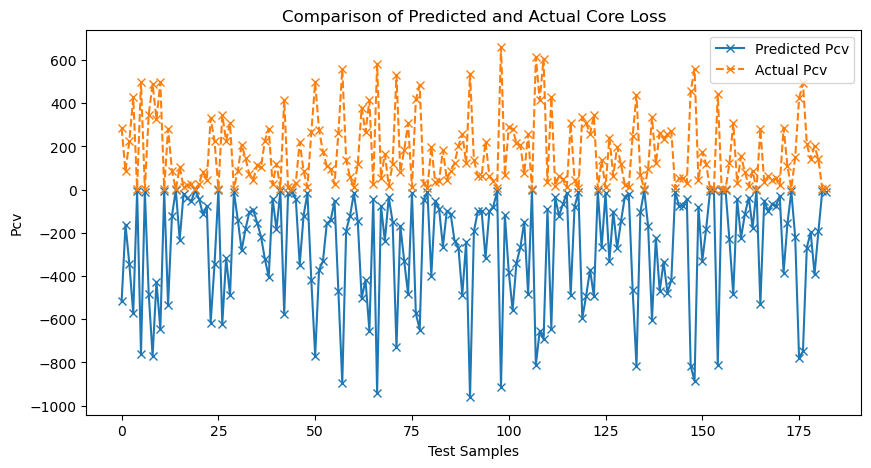

Relative Log Error: nan
AVG Log Error: nan
95-PRCT Log Error: nan
99th Percentile Log Error: nan
MAX Log Error: nan
MIN Log Error: nan


C:\Users\USER\AppData\Local\Temp\ipykernel_4484\4217105746.py:64: RuntimeWarning: invalid value encountered in log10
  np.log10(yy_pred + 1e-12) - np.log10(measured_Pcv + 1e-12)) * 100


預測結果已匯出至 ./Output/CH467160_predictions.csv


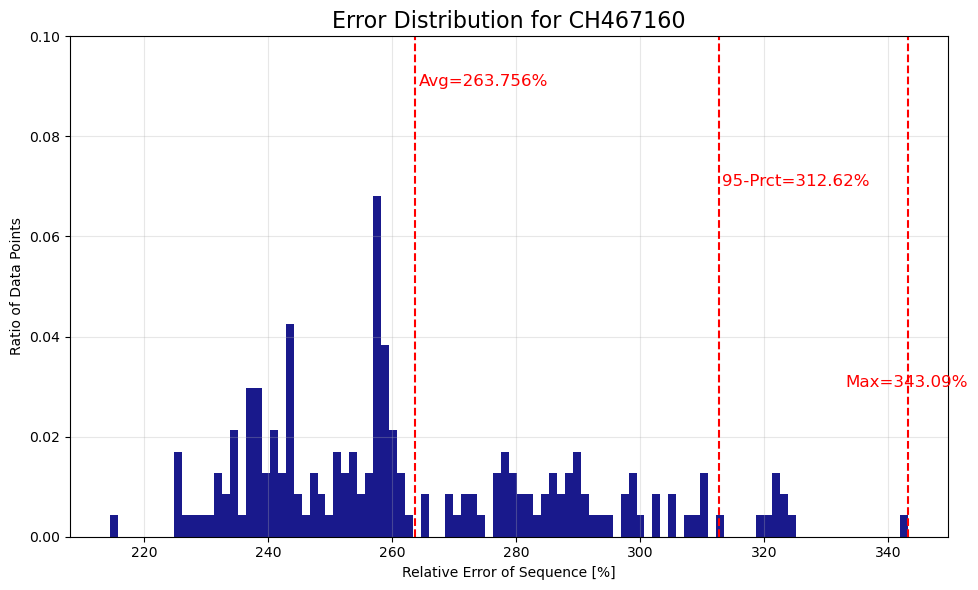

ValueError: autodetected range of [nan, nan] is not finite

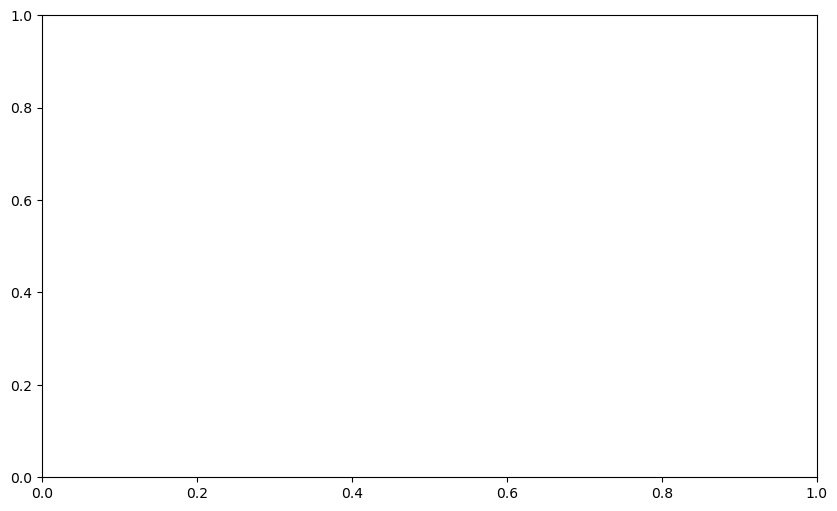

In [206]:
if __name__ == "__main__":

    # 取得原始資料（未降階）
    data_B, data_F, data_T, data_H, data_Pcv, data_Hdc, data_N = load_dataset(
        material)

    norm = normsDict[material]

    test_loader = get_dataloader(data_B, data_F, data_T, data_H, data_N,
                                 data_Hdc, data_Pcv, norm)

    test_model(test_loader, data_Pcv, data_B, data_H)